In [10]:
using PETScBinaryIO
using SparseArrays
using LinearAlgebra
using Statistics
using Makie
using BALUtils
using StaticArrays
using Rotations

In [65]:
J = readpetsc("../ba-tao/ladybug-3-jacobian.petsc")[1]
sol = readpetsc("../ba-tao/ladybug-3-solution.petsc")[1]
nc = 3
np = div(length(sol) - nc*9, 3)
poses = reshape(sol[1:nc*9], 9, :)
points = reshape(sol[(nc*9+1):end], 3, :)

3×688 Array{Float64,2}:
 -0.612      1.7075    -0.37337  …   1.64179  -11.4278    1.52961  
  0.571759   0.953869   1.53588      1.0337   -70.6587    0.0710439
 -1.84708   -6.87717   -4.78242     -9.01537  -50.6447  -11.3755   

In [196]:
# translation, rotation, and instrinsic parts of the poses
trange = 4:6
rrange = 1:3
irange = 7:9

function rodrigues_rotate(angle_axis, point)
    theta = norm(angle_axis)
    axis = normalize(angle_axis)
    point * cos(theta) + cross(axis, point) * sin(theta) + axis * dot(axis, point) * (1 - cos(theta))
end

function camera_centers(poses)
    ts = map(1:nc) do i
        R = poses[rrange, i]
        t = poses[trange, i]
        - rodrigues_rotate(-R, t)
    end
    hcat(ts...)
end

center = mapslices(mean, hcat(camera_centers(poses), points), dims=2)[:]
#center = mapslices(mean, camera_centers(poses), dims=2)[:]

function linear_rotation_cameras(poses, axis, center)
    f(x) = [x.sx,x.sy,x.sz]
    ts = map(1:nc) do i
        R = poses[rrange, i]
        t = poses[trange, i]
        alpha = norm(R)
        r = R/alpha
        a = axis
        0.5*abs(csc(alpha/2))*(r*(-2*acos(cos(alpha/2))*cos(alpha/2)+sqrt(2-2*cos(alpha)))*dot(r,-a)+2*acos(cos(alpha/2))*(-a*cos(alpha/2)+cross(r,-a)*sin(alpha/2)))
    end
    rot = hcat(ts...)
    vcat(rot, zeros(3, nc), zeros(3, nc))
end

function linear_rotation_points(points, axis, center)
    mapslices(x -> cross(axis, x - center), points, dims=1)
end

x_rot = vcat(linear_rotation_cameras(poses, [1, 0, 0], center)[:], linear_rotation_points(points, [1, 0, 0], center)[:])
y_rot = vcat(linear_rotation_cameras(poses, [0, 1, 0], center)[:], linear_rotation_points(points, [0, 1, 0], center)[:])
z_rot = vcat(linear_rotation_cameras(poses, [0, 0, 1], center)[:], linear_rotation_points(points, [0, 0, 1], center)[:])

function linear_translation_poses(poses, direction)
    # Poses are transformations from the world into the camera plane
    # expressed as Rx + t. We really want the camera center and its rotation.
    # We can convert to center + rotation using c = -R^T t and back with t = -R * c.
    ps = map(1:nc) do i
        R = poses[rrange, i]
        - rodrigues_rotate(R, direction[:, i])
    end
    hcat(ps...)
end

function scaling_poses(poses, center)
    # c = -R' t
    # -R (c - center)
    # t + R center
    ps = map(1:nc) do i
        R = poses[rrange, i]
        poses[trange, i] + rodrigues_rotate(R, center)
    end
    hcat(ps...)
end

x_trans = vcat(vcat(zeros(3, nc), linear_translation_poses(poses, [1, 0, 0] .+ 0 * poses[trange, :]), zeros(3, nc))[:], vcat(ones(1, np), zeros(2, np))[:])
y_trans = vcat(vcat(zeros(3, nc), linear_translation_poses(poses, [0, 1, 0] .+ 0 * poses[trange, :]), zeros(3, nc))[:], vcat(zeros(1, np), ones(1, np), zeros(1, np))[:])
z_trans = vcat(vcat(zeros(3, nc), linear_translation_poses(poses, [0, 0, 1] .+ 0 * poses[trange, :]), zeros(3, nc))[:], vcat(zeros(2, np), ones(1, np))[:])

scaling = vcat(vcat(zeros(3, nc), scaling_poses(poses, center), zeros(3, nc))[:], (points .- center)[:])

x_rot

2091-element Array{Float64,1}:
  -0.8921623584692526  
  -0.5604241326483965  
  -0.05050486974820462 
   0.0                 
   0.0                 
   0.0                 
   0.0                 
   0.0                 
   0.0                 
  -0.9552824752439438  
  -0.3595944451464225  
  -0.060422334879157054
   0.0                 
   ⋮                   
  -0.0                 
   3.116068915049528   
   1.0687720072751121  
  -0.0                 
   5.255174687722115   
   0.8316850225260456  
   0.0                 
  46.884516252197436   
 -70.86074394027504    
   0.0                 
   7.615317190322091   
  -0.13097113416065784 

In [200]:
norm(J * x_rot)
a = 1:nc*9
b = (nc*9+1):length(sol)
H = J' * J
S = H[a,a] - H[a,b] * inv(Array(H[b,b])) * H[b,a]
dot(x_trans[1:nc*9], scaling[1:nc*9])
norm(S * scaling[a])
dot(x_rot, y_rot)

-1596.523727399869

In [78]:
function draw_diff!(scene :: Scene, initial :: Array, change :: Array, scale :: Float64; kwargs...)
    moved = initial .+ change * scale
    paired = reshape(vcat(initial, moved), size(initial,1), :)
    linesegments!(scene, paired[1,:], paired[2,:], paired[3,:], transparency=true; kwargs...)
end

ts = map(1:nc) do i
    R = poses[rrange, i]
    t = reshape(x_rot[1:nc*9], 9, :)[trange, i]
    - rodrigues_rotate(-R, t)
end
x_rot_ = hcat(ts...)

scene = Scene()

mag = 1e-8

cameras = mapslices(x -> BALUtils.Camera(x), poses, dims=1)
centers = hcat(Vector.(BALUtils.center.(cameras))...)
centers_rot = mapslices(x -> RotX(mag) * x, centers, dims=1)
rots = mapslices(x -> rodrigues_rotate([1,0,0] * 1e-4, rodrigues_rotate(x, [0,0,-1])), -poses[rrange, :], dims=1)
rots_old = mapslices(x -> rodrigues_rotate(x, [0,0,-1]), -poses[rrange, :], dims=1)

draw_diff!(scene, centers_rot, rots, 1.0)
draw_diff!(scene, centers, rots_old, 1.0, color=:green)
scatter!(scene, centers[1,:], centers[2,:], centers[3,:], color=:blue, transparency=true)
scatter!(scene, centers_rot[1,:], centers_rot[2,:], centers_rot[3,:], color=:red, transparency=true)
scatter!(scene, [0], [0], [0], transparency=true)
rots - rots_old

3×3 Array{Float64,2}:
 0.0         0.0         0.0       
 9.94279e-5  9.92858e-5  9.95247e-5
 8.15048e-6  4.97856e-6  8.26463e-6

In [128]:
ts = map(1:nc) do i
    R = poses[rrange, i]
    t = poses[trange, i]
    c = - rodrigues_rotate(-R, t)
    c_rot = RotX(mag) * c
    - rodrigues_rotate(R, c_rot - c)
end
rtdiff = hcat(ts...)

axis = [1,0,0]
ts = map(1:nc) do i
    R = poses[rrange, i]
    t = poses[trange, i]
    # c = - R^T t
    c = - rodrigues_rotate(-R, t)
    -rodrigues_rotate(R, cross(axis, c))
end
analytical = hcat(ts...)
analytical = analytical 

lrt = linear_rotation_cameras(poses, [1,0,0], [0,0,0])[trange,:]

display("Difference between approximation and analytical for translation for rotation")
display(maximum(abs.(rtdiff/mag - lrt)))

#scene = Scene()
#draw_diff!(scene, centers, diff, 1.0)
#draw_diff!(scene, centers, analytical, 1.0, color=:green)
#scatter!(scene, centers[1,:], centers[2,:], centers[3,:], color=:blue, transparency=true)

"Difference between approximation and analytical for translation for rotation"

5.170206103521924e-11

In [129]:
f(x) = [x.sx, x.sy, x.sz]
rvec = RotX(mag)
ts = map(1:nc) do i
    # Composing two rodrigues vectors
    R = poses[rrange, i]
    alpha = norm(R)
    beta = norm(f(RodriguesVec(rvec)))
    r = R/alpha
    a = -f(RodriguesVec(rvec))/beta
    gamma = 2 * acos(cos(alpha/2)*cos(beta/2)-sin(alpha/2)*sin(beta/2)*dot(r,a))
    x = (sin(alpha/2)*cos(beta/2)*r+cos(alpha/2)*sin(beta/2)*a+sin(alpha/2)*sin(beta/2)*cross(r,a))/sin(gamma/2)
    # gamma * x is the new rodrigues vector
    gamma * x - f(RodriguesVec(R...))
end
rdiff = hcat(ts...)
lrc = linear_rotation_cameras(poses, [1,0,0], [0,0,0])[rrange,:]
display("Difference between aproximation and analytical for rotations")
display(maximum(abs.(lrc - rdiff/mag)))

rvec = RotX(mag)
pdiff = mapslices(p -> rvec * p, points, dims=1) - points
lr = linear_rotation_points(points, [1,0,0], [0,0,0])
display("Difference between approximation and analytical for points")
# display(pdiff/mag - lr)
display(maximum(abs.(lr - pdiff/mag)))

"Difference between aproximation and analytical for rotations"

1.941149246897922e-8

"Difference between approximation and analytical for points"

4.5389752045821297e-7

In [133]:
x_rot_diff = vcat(vcat(rdiff, rtdiff, zeros(3, nc))[:], pdiff[:])
x_rot = vcat(linear_rotation_cameras(poses, [1, 0, 0], [0,0,0])[:], linear_rotation_points(points, [1, 0, 0], [0,0,0])[:])
@show norm(x_rot - x_rot_diff/mag)
@show norm(J * (x_rot_diff/mag))
@show norm(J * x_rot)
@show(norm(x_rot_diff))
@show(norm(x_rot))
;

norm(x_rot - x_rot_diff / mag) = 7.523217400056974e-7
norm(J * (x_rot_diff / mag)) = 60.48915467426319
norm(J * x_rot) = 60.48916960930573
norm(x_rot_diff) = 1.5833520174483587e-6
norm(x_rot) = 158.33520170217636


In [39]:
S = svd(Array(J))

SVD{Float64,Float64,Array{Float64,2}}([0.0175887 0.0364161 … -0.033683 0.154765; 0.0341418 -0.0137461 … -0.0812019 0.373101; … ; 4.16692e-6 2.11099e-5 … 0.00477679 0.00637908; 1.58109e-5 -6.0465e-6 … 0.0061588 0.00822465], [11391.5, 10653.2, 10112.2, 10050.0, 9733.14, 9185.16, 6413.95, 4950.32, 4278.46, 3823.19  …  0.00920695, 0.000537009, 0.000143769, 5.0914e-12, 3.49835e-12, 1.03934e-12, 1.02684e-12, 5.41843e-13, 3.85895e-13, 1.49692e-13], [0.516153 -0.808483 … -4.03126e-9 1.72069e-8; -0.80402 -0.50064 … -1.2561e-7 7.61335e-10; … ; 0.0 -0.00076416 … 0.0308486 -0.00115703; 0.0 0.000228222 … 0.0176778 0.0314134])

In [94]:
display("Condition number including near null space")
S.S[1]/S.S[end]

"Condition number including near null space"

7.609939746577538e16

8×8 Array{Float64,2}:
 1.0  -1.19522e-15  -1.11148e-16  -2.7787e-17   …  -2.7787e-17     2.3429    
 0.0  -1.0          -2.60209e-18   3.72966e-17      1.0617e-16   -84.6639    
 0.0   0.0           1.0          -4.21538e-16      2.77556e-17  -41.9554    
 0.0   0.0           0.0           1.0             -3.95734e-18   87.0748    
 0.0   0.0           0.0           0.0              2.05565e-16   35.227     
 0.0   0.0           0.0           0.0          …  -1.21864e-16   84.4709    
 0.0   0.0           0.0           0.0              1.0           13.3431    
 0.0   0.0           0.0           0.0              0.0            1.41804e-8

2091-element Array{Float64,1}:
  0.0004882948611869367 
  0.00012059948557952478
  4.2360814875886394e-5 
 -0.0006661324796943981 
 -0.008905942506410114  
  0.04381683281243792   
 -0.024270290518752746  
 -2.333122054709591e-5  
  1.406424575174899e-6  
  0.00048615198502544076
  1.7496187511777532e-5 
  4.339551681403325e-5  
 -0.004535707750141106  
  ⋮                     
 -0.012589092318768005  
 -0.010674691050582684  
  0.034611868329846265  
 -0.014314819685900879  
 -0.008651810584847545  
  0.05674750354879433   
  0.018848225218485334  
  0.11891931856109415   
  0.09204805601860871   
 -0.012525728384303799  
  0.0010514791182385645 
  0.07700060170620902   

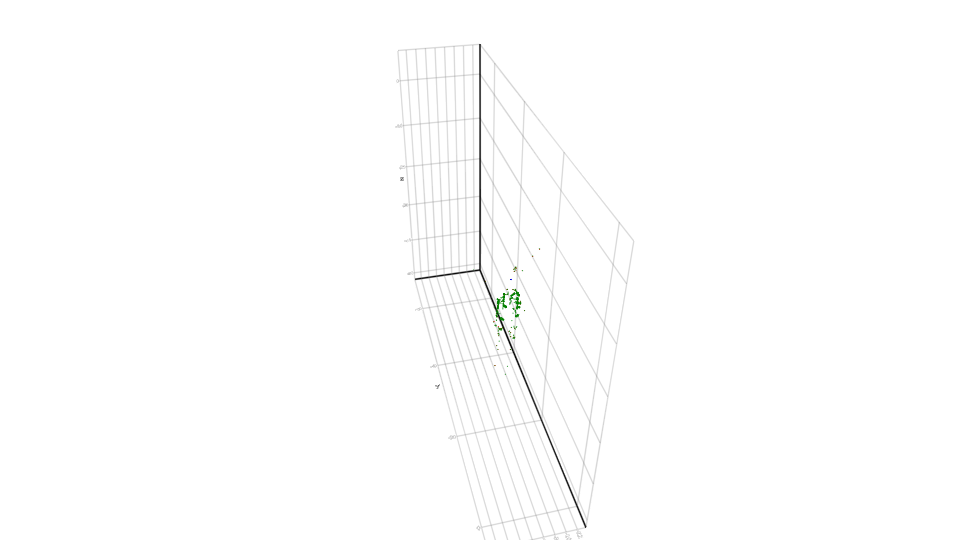

In [166]:
Q, R = qr(hcat(S.V[:,end-6:end], x_rot))
display(R)
v = Q[:, 8]
display(v)
r = reshape(v[1:nc*9], 9, :)
t = reshape(v[(nc*9+1):end], 3, :)
cts = map(1:nc) do i
    R = poses[rrange, i]
    - rodrigues_rotate(-R, r[trange, i])
end
ct = hcat(cts...)

x_rot_ = reshape(x_rot[1:nc*9], 9, :)
ct2s = map(1:nc) do i
    R = poses[rrange, i]
    - rodrigues_rotate(-R, x_rot_[trange, i])
end
ct2 = hcat(ct2s...)
scene = Scene()
draw_diff!(scene, centers, ct, 1.0, color=:black)
draw_diff!(scene, centers, ct2, 1.0, color=:orange)
draw_diff!(scene, points, t, 1.0, color=:red)
scatter!(scene, centers[1,:], centers[2,:], centers[3,:], markersize=0.1, color=:blue, transparency=true)
scatter!(scene, points[1,:], points[2,:], points[3,:], markersize=0.1, color=:green, transparency=true)